<a href="https://colab.research.google.com/github/AmelxJamal/STEM-Away-Internship/blob/master/Notebook_STEM_Away.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 3.3 MB/s 
     |████████████████████████████████| 4.7 MB 23.9 MB/s 
     |████████████████████████████████| 1.3 MB 53.7 MB/s 
     |████████████████████████████████| 101 kB 14.1 MB/s 
     |████████████████████████████████| 596 kB 65.7 MB/s 
     |████████████████████████████████| 6.6 MB 58.2 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=40748711f95e685761580f16b4cabf85224895ee16ca36d41b2c1231eec1e361
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


# Kaggle Quora Dataset

In [3]:
!pip install kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 3.3 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=982244b90a3fd3a8f92a8a91c0e3ed008151ed0b6da4851711aee8de3c7c88dd
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [4]:
!mkdir ~/.kaggle

In [5]:
!cp /content/kaggle.json /root/.kaggle

In [6]:
!chmod 600 /root/.kaggle/kaggle.json

In [7]:
import os
os.environ["KAGGLE_CONFIG_"] =' /content/kaggle.json'

In [8]:
!kaggle competitions download -c quora-question-pairs

 95% 293M/309M [00:02<00:00, 104MB/s]
100% 309M/309M [00:02<00:00, 123MB/s]


In [9]:
!unzip /content/quora-question-pairs.zip

Archive:  /content/quora-question-pairs.zip
  inflating: sample_submission.csv.zip  
  inflating: test.csv                
  inflating: test.csv.zip            
  inflating: train.csv.zip           


In [10]:
!unzip /content/train.csv.zip

Archive:  /content/train.csv.zip
  inflating: train.csv               


In [11]:
train_df = pd.read_csv('/content/train.csv')
train_df.head(10)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


In [12]:
test_df = pd.read_csv('/content/test.csv')
test_df.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


# Retrieval System

In [13]:
train_df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

In [14]:
x = train_df[['id', 'qid1', 'qid2', 'question1', 'question2']]
y = train_df.is_duplicate
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.998, random_state = 0)

In [15]:
x_train.shape

(808, 5)

In [16]:
import json
from sentence_transformers import SentenceTransformer, CrossEncoder, util
import gzip
import os
import torch
import pandas as pd

if not torch.cuda.is_available():
    print("Warning: No GPU found. Please add GPU to your notebook")


#We use the Bi-Encoder to encode all passages, so that we can use it with sematic search
bi_encoder = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
bi_encoder.max_seq_length = 256     #Truncate long passages to 256 tokens
top_k = 32                          #Number of passages we want to retrieve with the bi-encoder

#The bi-encoder will retrieve 100 documents. We use a cross-encoder, to re-rank the results list to improve the quality
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

# df = pd.read_csv('Questions.csv') --> kaggle dataset
# passages = df.body[:9000].to_numpy()


qoura = x_train.question1.to_numpy()
passages = qoura
print("Passages:", len(passages))

# We encode all passages into our vector space. This takes about 5 minutes (depends on your GPU speed)
corpus_embeddings = bi_encoder.encode(passages, convert_to_tensor=True, show_progress_bar=True)

Downloading:   0%|          | 0.00/737 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/11.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/383 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.8k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Passages: 808


Batches:   0%|          | 0/26 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


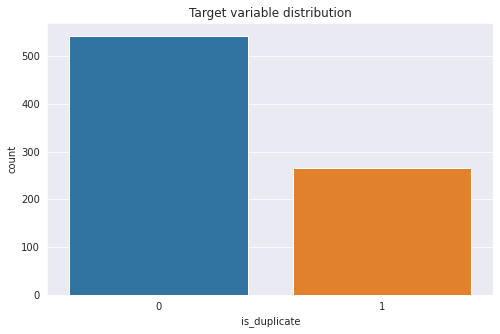

In [17]:
# Target variable distribution
train_sampled = x_train
train_sampled['is_duplicate'] = y_train
sns.set_style('darkgrid')
plt.figure(figsize=(8, 5))
sns.countplot(train_sampled["is_duplicate"])
plt.title('Target variable distribution')
plt.show()

In [18]:
# This function will search the corpus for passages that match the query
def search(query, top=3):
   
    ##### Sematic Search #####
    # Encode the query using the bi-encoder and find potentially relevant passages
    question_embedding = bi_encoder.encode(query, convert_to_tensor=True)
    question_embedding = question_embedding.cuda()
    hits = util.semantic_search(question_embedding, corpus_embeddings, top_k=top_k)
    hits = hits[0]  # Get the hits for the first query

    ##### Re-Ranking #####
    # Now, score all retrieved passages with the cross_encoder
    cross_inp = [[query, passages[hit['corpus_id']]] for hit in hits]
    cross_scores = cross_encoder.predict(cross_inp)

    # Sort results by the cross-encoder scores
    for idx in range(len(cross_scores)):
        hits[idx]['cross-score'] = cross_scores[idx]

    # Output of top-k hits from bi-encoder
    
    bi_encoder_hits = sorted(hits, key=lambda x: x['score'], reverse=True)
    
    bi_list, scores = [],[]
    for hit in bi_encoder_hits[0:top]:
        bi_list.append(passages[hit['corpus_id']])
        scores.append(hit['score'])

    # Output of top-k hits from re-ranker
   
    cross_encoder_hits = sorted(bi_encoder_hits, key=lambda x: x['cross-score'], reverse=True)
    cross_list, scores_cross = [], []
    for hit in cross_encoder_hits[0:3]:
        cross_list.append((passages[hit['corpus_id']]))
        scores_cross.append(hit['cross-score'])
    return bi_list, cross_list, scores, scores_cross

In [19]:
from collections import defaultdict
def compute_hits(embeddings, questions_list, model = 'cross', top=3):
  hits_dict = defaultdict(lambda: 0.0)
  for idx, question in enumerate(questions_list):
    hits = []
    bi_hits, cross_hit, bi_scores, cross_scores = search(question, top=top)
    if model == 'bi':
      hits_dict[idx] = (bi_hits, bi_scores)
    else:
      hits_dict[idx] = (cross_hit, cross_scores)
  return hits_dict

In [20]:
def evaluate(list_hits, list_question2, labels):
  counts, length, TP, FP, TN, FN = 0,0,0,0,0,0
  TP_score, FP_score, TN_score, FN_score = [], [], [], []
  for idx, q in enumerate(list_question2):
      length +=1
      if labels[idx] == 1 and q in list_hits[idx][0]:
        counts+=1
        TP+=1
        # TP_score.append(list_hits[idx][1][])
      if labels[idx] == 0 and q not in list_hits[idx][0]:
        counts+=1
        TN+=1
      if labels[idx] == 1 and q not in list_hits[idx][0]:
        FN+=1
      if labels[idx] == 0 and q in list_hits[idx][0]:
        FP+=1

  accuracy = (counts/length)*100
  sensitivity = TP/(TP+FN)
  specificity = TN/(TN+FP)
  FPR = 1-specificity
  return accuracy, sensitivity, specificity, FPR, TP,TN,FP,FN

In [21]:
hits = compute_hits(corpus_embeddings, x_train.question2.to_numpy(),top=5)

In [22]:
accuracy, sensitivity, specificity, FPR , TP, TN, FP, FN= evaluate(hits, x_train.question1.to_numpy(),x_train.is_duplicate.to_numpy())

In [23]:
accuracy, sensitivity, specificity, FPR, TP,TN,FP,FN

(44.67821782178218,
 0.9887218045112782,
 0.18081180811808117,
 0.8191881918819188,
 263,
 98,
 444,
 3)

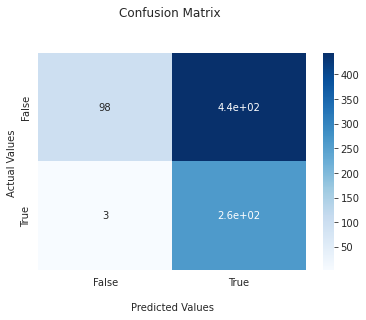

In [24]:
import seaborn as sns

cf = np.array([
    [TN, FP],
    [FN, TP]
])
ax = sns.heatmap(cf, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [25]:
for query in train_df.question2[:2].to_numpy():
  search(query)

#Pinecone

In [26]:
!pip install -qU pip pinecone-client

     |████████████████████████████████| 2.0 MB 5.1 MB/s 
     |████████████████████████████████| 175 kB 66.4 MB/s 
     |████████████████████████████████| 269 kB 69.3 MB/s 
     |████████████████████████████████| 58 kB 3.1 MB/s 


In [27]:
import pinecone
import os

api_key = 'f158288a-05ab-4c9f-8674-4a23758efffe'
pinecone.init(api_key=api_key, environment='us-west1-gcp')

In [28]:
import pinecone.info

version_info = pinecone.info.version()
server_version = ".".join(version_info.server.split(".")[:2])
client_version = ".".join(version_info.client.split(".")[:2])

assert client_version == server_version, "Please upgrade pinecone-client."

In [29]:
# Giving our index a name
index_name = "stem-away"
# Delete the index, if an index of the same name already exists
if index_name in pinecone.list_indexes():
    pinecone.delete_index(index_name)

In [30]:
dimensions = 384
pinecone.create_index(name=index_name, dimension=dimensions) # , metric="cosine", shards=1

In [31]:
index = pinecone.Index(index_name=index_name)

In [32]:
x_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
201990,201990,304141,304142,What is it like working with Elijah Wood?,What is it like to work with Elijah Wood?,0
360317,360317,490095,490096,What is something that amazes you?,What are the 10 most amazing things animals ca...,0
323329,323329,10538,313763,What type of food should I eat to lose weight?,What should I eat while losing weight?,1
362380,362380,492286,492287,How much cloud space is allocated for a Blogsp...,How much can I earn from Adsense on a Blogspot...,0
92311,92311,154551,154552,I wanted to do bcom .i have taken physical edu...,I have taken general maths in SSC and I want t...,0


In [33]:
len(x_train)

808

In [34]:
temp = pd.DataFrame(corpus_embeddings.cpu().numpy())
temp.head()

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,0.003152,0.038828,0.026901,-0.040638,-0.144636,0.026495,0.043506,-0.051917,-0.051698,-0.000405,...,0.083308,-0.071614,0.027393,-0.071938,-0.035725,-0.025033,0.088633,-0.033141,-0.006565,0.133448
1,-0.014288,0.004082,0.016820,0.087492,0.029660,-0.079683,0.210575,-0.024216,-0.049562,-0.072375,...,0.024525,0.016527,-0.017530,0.044806,0.007338,0.047060,0.193736,0.078936,-0.041761,-0.013536
2,0.012521,0.011083,0.023680,-0.015385,0.015189,0.035435,0.092652,-0.039161,-0.022873,0.016119,...,-0.004785,0.058973,0.077339,-0.019092,-0.022906,-0.055296,0.057317,0.003504,0.013691,0.002120
3,0.022891,-0.063757,0.020371,0.040703,0.025737,-0.023490,0.054976,-0.003141,0.040929,0.068224,...,0.015075,-0.020086,-0.023260,-0.024655,-0.070663,-0.057975,-0.042468,0.008290,-0.015142,-0.004042
4,-0.009789,0.000939,-0.010672,-0.026875,-0.077500,0.001792,0.010935,0.043297,-0.084401,0.023772,...,0.036036,0.097051,0.047306,-0.006336,-0.103112,0.129510,0.005415,-0.049905,-0.011267,-0.009659


In [35]:
vectors_df = pd.DataFrame()
vectors_df['id'] = x_train['id'].apply(lambda x : str(x))
vectors_df['vector']= temp.values.tolist()
vectors_df.head()

,id,vector
201990,201990,"[0.003152142046019435, 0.03882816061377525, 0...."
360317,360317,"[-0.014288224279880524, 0.0040819994173944, 0...."
323329,323329,"[0.012520530261099339, 0.011083300225436687, 0..."
362380,362380,"[0.02289072424173355, -0.06375698745250702, 0...."
92311,92311,"[-0.009788676165044308, 0.0009392699575982988,..."


In [36]:
import itertools

def chunks(iterable, batch_size=100):
    it = iter(iterable)
    chunk = tuple(itertools.islice(it, batch_size))
    while chunk:
        yield chunk
        chunk = tuple(itertools.islice(it, batch_size))

In [37]:
for batch in chunks(zip(vectors_df.id, vectors_df.vector)):
    index.upsert(vectors=batch)

In [38]:
query_embeddings = bi_encoder.encode(x_train.question2[:10].to_numpy(), convert_to_tensor=True, show_progress_bar=True)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [45]:
# query pinecone
query_results = [index.query(xq, top_k=5) for xq in query_embeddings.tolist()]

# show the results
for question, res in zip(x_train.question2[:10].to_numpy(), query_results):
    print("\n\n\n Original question : " + str(question))
    print("\n Most similar questions based on pinecone vector search: \n")

    ids = [match.id for match in res.matches]
    scores = [match.score for match in res.matches]
    df_result = pd.DataFrame(
        {
            "id": ids,
            "question": [
                x_train[x_train.id == int(_id)].question1.values[0] for _id in ids 
            ],
            "score": scores,
        }
    )
    print(df_result)




 Original question : What is it like to work with Elijah Wood?

 Most similar questions based on pinecone vector search: 

       id                                      question     score
0  201990     What is it like working with Elijah Wood?  0.983413
1  248867             How are Goku and Vegeta brothers?  0.266303
2  328084              Good chimney for Indian kitchen?  0.263500
3  200794                    Where is teach mashal art?  0.259378
4  259978  Where is the real sword of Ashoka the great?  0.251210



 Original question : What are the 10 most amazing things animals can do?

 Most similar questions based on pinecone vector search: 

       id                                           question     score
0  233274  What are some cute-looking but fierce wild ani...  0.530682
1  174743  What is the most interesting thing in the inte...  0.453967
2    9630            What are the 10 must see action movies?  0.422938
3  281505  What are the five most important things for a .

In [46]:
pinecone.delete_index(index_name)

# Pinecone Hybrid Search

In [47]:
!pip install -qU pip pinecone-client

In [59]:
!pip install sentence-transformers sacremoses

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=5f94863554eeb91a395d105aabc0a60c5f8fc753ea0f6e724d3d3ea0779a7014
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses


In [48]:
import pinecone
import os

api_key = 'f158288a-05ab-4c9f-8674-4a23758efffe'
pinecone.init(api_key=api_key, environment='us-west1-gcp')

In [49]:
import pinecone.info

version_info = pinecone.info.version()
server_version = ".".join(version_info.server.split(".")[:2])
client_version = ".".join(version_info.client.split(".")[:2])

assert client_version == server_version, "Please upgrade pinecone-client."

In [108]:
# Giving our index a name
index_name = "stem-away"
# Delete the index, if an index of the same name already exists
if index_name in pinecone.list_indexes():
    pinecone.delete_index(index_name)

In [109]:
dimensions = 384
pinecone.create_index(name=index_name, dimension=dimensions) # , metric="cosine", shards=1

In [110]:
index = pinecone.Index(index_name=index_name)

In [66]:
questions_data = pd.read_csv('/content/Questions.csv')
questions_data.head(10)

,id,title,body,accepted_answer_id,answer_count,comment_count,community_owned_date,creation_date,favorite_count,last_activity_date,last_edit_date,last_editor_display_name,last_editor_user_id,owner_display_name,owner_user_id,parent_id,post_type_id,score,tags,view_count
0,320268,Html.ActionLink doesn’t render # properly,<p>When using Html.ActionLink passing a string...,NaN,0,0,NaN,2008-11-26 10:42:37.477000+00:00,0.0,2009-02-06 20:13:54.370000+00:00,NaN,NaN,NaN,Paulo,NaN,NaN,1,0,asp.net-mvc,380
1,324003,Primitive recursion,<p>how will i define the function 'simplify' ...,NaN,0,0,NaN,2008-11-27 15:12:37.497000+00:00,0.0,2012-09-25 19:54:40.597000+00:00,2012-09-25 19:54:40.597000+00:00,Marcin,1288.0,NaN,41000.0,NaN,1,0,haskell|lambda|functional-programming|lambda-c...,488
2,390605,While vs. Do While,<p>I've seen both the blocks of code in use se...,390608.0,0,0,NaN,2008-12-24 01:49:54.230000+00:00,2.0,2008-12-24 03:08:55.897000+00:00,NaN,NaN,NaN,Unkwntech,115.0,NaN,1,0,language-agnostic|loops,11086
3,413246,Protect ASP.NET Source code,<p>Im currently doing some research in how to ...,NaN,0,0,NaN,2009-01-05 14:23:51.040000+00:00,0.0,2009-03-24 21:30:22.370000+00:00,2009-01-05 14:42:28.257000+00:00,Tom Anderson,13502.0,Velnias,NaN,NaN,1,0,asp.net|deployment|obfuscation,4811
4,454921,"Difference between ""int[] myArray"" and ""int my...",<blockquote>\n <p><strong>Possible Duplicate:...,454928.0,0,0,NaN,2009-01-18 10:22:52.177000+00:00,0.0,2009-01-18 10:30:50.930000+00:00,2017-05-23 11:49:26.567000+00:00,NaN,-1.0,Evan Fosmark,49701.0,NaN,1,0,java|arrays,795
5,472695,Looking for WPF/XAML example that gets XML fro...,<p>I can imagine WPF has a very easy way to gr...,NaN,0,2,NaN,2009-01-23 12:21:50.073000+00:00,NaN,2009-01-23 13:23:29.543000+00:00,2009-01-23 12:41:17.037000+00:00,Fabian Steeg,18154.0,Edward Tanguay,4639.0,NaN,1,0,.net|wpf|xaml|rest,653
6,587584,What is the preferred way to declare a Java ar...,<blockquote>\n <p><strong>Possible Duplicate:...,587594.0,0,0,NaN,2009-02-25 19:57:22.633000+00:00,0.0,2009-02-25 23:37:23.213000+00:00,2017-05-23 12:20:37.303000+00:00,Eddie,-1.0,Simon,24039.0,NaN,1,0,java|arrays|declaration,626
7,597572,How do I create a windows service with Python,<p>I really need my python program to run as a...,NaN,0,0,NaN,2009-02-28 05:47:08.330000+00:00,0.0,2020-10-14 06:15:14.207000+00:00,2020-10-14 06:15:14.207000+00:00,eliben,100297.0,minty,4491.0,NaN,1,0,python|windows|service,3494
8,612711,Best C# Profiler?,<p>Recently I used RedGate ANTS profiler which...,NaN,0,0,NaN,2009-03-04 22:16:01.557000+00:00,2.0,2013-01-14 21:17:03.763000+00:00,2010-01-25 15:15:51.767000+00:00,Gortok,164901.0,Joan Venge,51816.0,NaN,1,0,c#|.net|performance|profiler,20899
9,651291,Securing a .NET Application,<h3>Duplicate:</h3>\n<blockquote>\n<p><a href=...,651375.0,0,0,NaN,2009-03-16 17:07:23.660000+00:00,1.0,2010-06-09 16:17:12.787000+00:00,2020-06-20 09:12:55.060000+00:00,Rich B,-1.0,beakersoft,19638.0,NaN,1,0,.net|security|obfuscation|reverse-engineering,5968


In [98]:
questions_embeddings = bi_encoder.encode(questions_data.title.to_numpy(), convert_to_tensor=True, show_progress_bar=True)

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

In [99]:
vectors_df = pd.DataFrame()
vectors_df['id'] = questions_data['id'].apply(lambda x : str(x))
vectors_df['vector']= pd.DataFrame(questions_embeddings.cpu().numpy()).values.tolist()
vectors_df.head()

,id,vector
0,320268,"[-0.025011537596583366, -0.07002244889736176, ..."
1,324003,"[-0.039439257234334946, 0.0774073377251625, -0..."
2,390605,"[0.08628430217504501, 0.06157788261771202, 0.0..."
3,413246,"[-0.04510904848575592, 0.032456353306770325, -..."
4,454921,"[0.00837804563343525, 0.0311595406383276, 0.01..."


In [100]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

tags_list = [tokenizer.tokenize(sentence.lower()) for sentence in questions_data.tags.to_numpy()]
tags_list[1]

['has',
 '##kell',
 '|',
 'lambda',
 '|',
 'functional',
 '-',
 'programming',
 '|',
 'lambda',
 '-',
 'calculus']

In [101]:
cleaned_tags = []
specials = ['|', '-', '_', '#','.']
for sentence in tags_list:
  res = [i for i in sentence if i not in specials]
  cleaned_tags.append(res)

cleaned_tags[6]

['java', 'arrays', 'declaration']

In [102]:
import itertools

def chunks(iterable, batch_size=100):
    it = iter(iterable)
    chunk = tuple(itertools.islice(it, batch_size))
    while chunk:
        yield chunk
        chunk = tuple(itertools.islice(it, batch_size))

In [111]:
upserts = []
for (id, embedding, tokens) in zip(vectors_df.id, vectors_df.vector, cleaned_tags):
    upserts.append((str(id), embedding, {'tokens': tokens}))

In [112]:
for batch in chunks(upserts):
    index.upsert(vectors=batch)

In [113]:
query_sentence = "How to print in python?"
xq = bi_encoder.encode(query_sentence).tolist()

In [114]:
result = index.query(xq, top_k=10, includeMetadata=True)
result

{'matches': [{'id': '724550',
              'metadata': {'tokens': ['java', '##script', 'j', '##sp']},
              'score': 0.586400509,
              'values': []},
             {'id': '744625',
              'metadata': {'tokens': ['error', 'logging', 'p', '##ys', '##60']},
              'score': 0.585803449,
              'values': []},
             {'id': '633743',
              'metadata': {'tokens': ['visual', 'c', '+', '+']},
              'score': 0.527547479,
              'values': []},
             {'id': '869829',
              'metadata': {'tokens': ['visual',
                                      'studio',
                                      'visual',
                                      'studio',
                                      '2008',
                                      'variables',
                                      'environment']},
              'score': 0.512947083,
              'values': []},
             {'id': '297911',
              'metadata': {

In [115]:
filters = ['python']
result = index.query(xq, top_k=10, filter={
    'tokens': {'$in': filters}})

ids = [int(x['id']) for x in result['matches']]
for i in ids:
    print(questions_data[questions_data.id == int(i)].title.values[0])

How does the win32com python.Interpreter work?
best way to print data in columnar format?
Python 2.5.2 continued
Python: convert alphabetically spelled out numbers to numerics?
How to Change Mouse Cursor in PythonCard
Python: Use the codecs module or use string function decode?
How to set up Python for .NET with Python 2.6.1?
Execution of a OS command from a Python daemon
learning python 3.0 on ubuntu
Python and subprocess


Old result from body embeddings 👇



In [97]:
filters = ['python']
result = index.query(xq, top_k=10, filter={
    'tokens': {'$in': filters}})

ids = [int(x['id']) for x in result['matches']]
for i in ids:
    print(questions_data[questions_data.id == int(i)].title.values[0])

best way to print data in columnar format?
Django Shell shortcut in Windows
How do I create a windows service with Python
How can I check if a box is alive or down using the ip address in Python?
Subtract from an input appended list with a running balance output
pinging mysql using mysql alchemy and python
mod_python.publisher always gives content type 'text/plain'
Can I use a List Comprehension to get Line Indexes from a file?
python, funny business with threads and IDEs?
How to make nntplib author name human readable?


In [116]:
pinecone.delete_index(index_name)

# Training

In [117]:
questions_df = pd.read_csv('/content/Questions.csv')
quesitons_clean = questions_df[questions_df['accepted_answer_id'].notna()]
quesitons_clean['accepted_answer_id'] = quesitons_clean['accepted_answer_id'].apply(lambda x: int(round(x)))
quesitons_clean.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,id,title,body,accepted_answer_id,answer_count,comment_count,community_owned_date,creation_date,favorite_count,last_activity_date,last_edit_date,last_editor_display_name,last_editor_user_id,owner_display_name,owner_user_id,parent_id,post_type_id,score,tags,view_count
2,390605,While vs. Do While,<p>I've seen both the blocks of code in use se...,390608,0,0,NaN,2008-12-24 01:49:54.230000+00:00,2.0,2008-12-24 03:08:55.897000+00:00,NaN,NaN,NaN,Unkwntech,115.0,NaN,1,0,language-agnostic|loops,11086
4,454921,"Difference between ""int[] myArray"" and ""int my...",<blockquote>\n <p><strong>Possible Duplicate:...,454928,0,0,NaN,2009-01-18 10:22:52.177000+00:00,0.0,2009-01-18 10:30:50.930000+00:00,2017-05-23 11:49:26.567000+00:00,NaN,-1.0,Evan Fosmark,49701.0,NaN,1,0,java|arrays,795
6,587584,What is the preferred way to declare a Java ar...,<blockquote>\n <p><strong>Possible Duplicate:...,587594,0,0,NaN,2009-02-25 19:57:22.633000+00:00,0.0,2009-02-25 23:37:23.213000+00:00,2017-05-23 12:20:37.303000+00:00,Eddie,-1.0,Simon,24039.0,NaN,1,0,java|arrays|declaration,626
9,651291,Securing a .NET Application,<h3>Duplicate:</h3>\n<blockquote>\n<p><a href=...,651375,0,0,NaN,2009-03-16 17:07:23.660000+00:00,1.0,2010-06-09 16:17:12.787000+00:00,2020-06-20 09:12:55.060000+00:00,Rich B,-1.0,beakersoft,19638.0,NaN,1,0,.net|security|obfuscation|reverse-engineering,5968
662,8066,.NET Interfaces,<p>Over the past few years I've changed from h...,8086,1,0,NaN,2008-08-11 18:30:44.893000+00:00,NaN,2013-04-04 15:51:01.583000+00:00,2013-04-04 15:51:01.583000+00:00,NaN,1612146.0,NaN,721.0,NaN,1,0,.net|user-controls|interface,811


In [118]:
no_dupes = quesitons_clean[['id','accepted_answer_id','body']]
no_dupes.head()

,id,accepted_answer_id,body
2,390605,390608,<p>I've seen both the blocks of code in use se...
4,454921,454928,<blockquote>\n <p><strong>Possible Duplicate:...
6,587584,587594,<blockquote>\n <p><strong>Possible Duplicate:...
9,651291,651375,<h3>Duplicate:</h3>\n<blockquote>\n<p><a href=...
662,8066,8086,<p>Over the past few years I've changed from h...


In [119]:
answers_df = pd.read_csv('/content/Answers.csv')
answers_clean = answers_df[answers_df['id'].notna()]
answers_clean.head()

,id,title,body,accepted_answer_id,answer_count,comment_count,community_owned_date,creation_date,favorite_count,last_activity_date,last_edit_date,last_editor_display_name,last_editor_user_id,owner_display_name,owner_user_id,parent_id,post_type_id,score,tags,view_count
0,18,NaN,<p>For a table like this:</p>\n\n<pre><code>CR...,NaN,NaN,2,NaN,2008-08-01 05:12:44.193000+00:00,NaN,2016-06-02 05:56:26.060000+00:00,2016-06-02 05:56:26.060000+00:00,Jeff Atwood,126039,phpguy,NaN,17,2,59,NaN,NaN
1,165,NaN,"<p>You can use a <a href=""http://sharpdevelop....",NaN,NaN,0,NaN,2008-08-01 18:04:25.023000+00:00,NaN,2019-04-06 14:03:51.080000+00:00,2019-04-06 14:03:51.080000+00:00,NaN,1721793,user2189331,NaN,145,2,10,NaN,NaN
2,1028,NaN,<p>The VB code looks something like this:</p>\...,NaN,NaN,0,NaN,2008-08-04 04:58:40.300000+00:00,NaN,2013-02-07 13:22:14.680000+00:00,2013-02-07 13:22:14.680000+00:00,NaN,395659,user2189331,NaN,947,2,8,NaN,NaN
3,1073,NaN,<p>My first choice would be a dedicated heap t...,NaN,NaN,0,NaN,2008-08-04 07:51:02.997000+00:00,NaN,2015-09-01 17:32:32.120000+00:00,2015-09-01 17:32:32.120000+00:00,NaN,45459,user2189331,NaN,1069,2,29,NaN,NaN
4,1260,NaN,<p>I found the answer. all you have to do is a...,NaN,NaN,0,NaN,2008-08-04 14:06:02.863000+00:00,NaN,2016-12-20 08:38:48.867000+00:00,2016-12-20 08:38:48.867000+00:00,NaN,1221571,Jin,NaN,1229,2,1,NaN,NaN


In [120]:
questions_df.head()

,id,title,body,accepted_answer_id,answer_count,comment_count,community_owned_date,creation_date,favorite_count,last_activity_date,last_edit_date,last_editor_display_name,last_editor_user_id,owner_display_name,owner_user_id,parent_id,post_type_id,score,tags,view_count
0,320268,Html.ActionLink doesn’t render # properly,<p>When using Html.ActionLink passing a string...,NaN,0,0,NaN,2008-11-26 10:42:37.477000+00:00,0.0,2009-02-06 20:13:54.370000+00:00,NaN,NaN,NaN,Paulo,NaN,NaN,1,0,asp.net-mvc,380
1,324003,Primitive recursion,<p>how will i define the function 'simplify' ...,NaN,0,0,NaN,2008-11-27 15:12:37.497000+00:00,0.0,2012-09-25 19:54:40.597000+00:00,2012-09-25 19:54:40.597000+00:00,Marcin,1288.0,NaN,41000.0,NaN,1,0,haskell|lambda|functional-programming|lambda-c...,488
2,390605,While vs. Do While,<p>I've seen both the blocks of code in use se...,390608.0,0,0,NaN,2008-12-24 01:49:54.230000+00:00,2.0,2008-12-24 03:08:55.897000+00:00,NaN,NaN,NaN,Unkwntech,115.0,NaN,1,0,language-agnostic|loops,11086
3,413246,Protect ASP.NET Source code,<p>Im currently doing some research in how to ...,NaN,0,0,NaN,2009-01-05 14:23:51.040000+00:00,0.0,2009-03-24 21:30:22.370000+00:00,2009-01-05 14:42:28.257000+00:00,Tom Anderson,13502.0,Velnias,NaN,NaN,1,0,asp.net|deployment|obfuscation,4811
4,454921,"Difference between ""int[] myArray"" and ""int my...",<blockquote>\n <p><strong>Possible Duplicate:...,454928.0,0,0,NaN,2009-01-18 10:22:52.177000+00:00,0.0,2009-01-18 10:30:50.930000+00:00,2017-05-23 11:49:26.567000+00:00,NaN,-1.0,Evan Fosmark,49701.0,NaN,1,0,java|arrays,795


In [121]:
ans = pd.DataFrame()
ans['accepted_answer_id'] = answers_clean['id']
ans['accepted_answer_id'] = ans['accepted_answer_id'].apply(lambda x: int(round(x)))
ans['body_2'] = answers_clean['body']

In [122]:
# answers_df.loc[answers_df['accepted_answer_id'] == 454928]
merged_df = no_dupes.merge(ans, on='accepted_answer_id', how='inner')
merged_df['label'] = 1
merged_df.head()

,id,accepted_answer_id,body,body_2,label
0,20899,25178,"<p>Two RAID volumes, VMware kernel/console run...",<p>It was the backplane. Both drives of the RA...,1
1,27889,28346,<p>I am trying to get SpecUnit to run in a con...,<p>You need to specify the full path to the as...,1
2,56859,58647,<p>In SCSF application I would like to display...,"<p>Assuming you're talking about Winforms, not...",1
3,62027,68148,"<p>I had to use a <a href=""http://msdn.microso...","<p>Does <a href=""http://geeknotes.wordpress.co...",1
4,68898,68914,<p>Does there exist a website service or set o...,"<p>I believe the <a href=""http://validator.w3....",1


In [123]:
merged_df.describe()

,id,accepted_answer_id,label
count,51.000000,51.000000,51.0
mean,400853.666667,406525.137255,1.0
std,192853.202959,191203.212923,0.0
min,20899.000000,25178.000000,1.0
25%,246996.500000,254659.000000,1.0
50%,434680.000000,446496.000000,1.0
75%,590776.000000,591229.500000,1.0
max,658484.000000,658507.000000,1.0


In [124]:
# nan_df_q = questions_df[questions_df['accepted_answer_id'].isna()]
# nan_df_a =  answers_df[answers_df['accepted_answer_id'].isna()]
# nan_questions = nan_df_q[['id','accepted_answer_id','body']]
# nan_answers = pd.DataFrame()
# nan_answers['accepted_answer_id'] = nan_df_a['id']
# nan_answers['accepted_answer_id'] = nan_answers['accepted_answer_id'].apply(lambda x: int(round(x)))
# nan_answers['body_2'] = nan_df_a['body']
# merged_nan = nan_questions.merge(nan_answers, on='accepted_answer_id', how='inner')
# merged_nan['label'] = 0
# merged_nan.head()

merged_df_2 = pd.DataFrame()
merged_df_2['id'] = answers_df[:52]['id']
merged_df_2['accepted_answer_id'] = answers_clean[100:152]['id'].to_numpy()
merged_df_2['body'] = answers_df[:52]['body']
merged_df_2['body_2'] = answers_clean[100:152]['body'].to_numpy()
merged_df_2['label'] = 0
merged_df_2.head()


,id,accepted_answer_id,body,body_2,label
0,18,64635,<p>For a table like this:</p>\n\n<pre><code>CR...,<p>If you are referring to using a custom imag...,0
1,165,64795,"<p>You can use a <a href=""http://sharpdevelop....",<pre><code>cout &lt;&lt; text &lt;&lt; i;\n</c...,0
2,1028,64807,<p>The VB code looks something like this:</p>\...,<p>Regular expressions are overkill for this s...,0
3,1073,64834,<p>My first choice would be a dedicated heap t...,<p>Try <kbd>Ctrl-x</kbd> followed by <kbd>Ctrl...,0
4,1260,64845,<p>I found the answer. all you have to do is a...,"<p>Also, if you want to get rid of the list of...",0


In [125]:
new_train_data = pd.concat([merged_df,merged_df_2])
# shuffle the data
indices = np.arange(len(new_train_data))
np.random.shuffle(indices)
new_train_data = new_train_data.iloc[indices]
new_train_data.head()

,id,accepted_answer_id,body,body_2,label
32,511140,511151,<p>I am using the following query to get the t...,"<p>You need to join twice, thus:</p>\n\n<pre><...",1
18,12143,66483,<p>I dropped the live database and deleted it....,<p>as a local variable in a C function:</p>\n\...,0
17,11775,66337,"<p>The <a href=""http://msdn.microsoft.com/en-u...",<p>The secret is to surround your whole thingi...,0
2,56859,58647,<p>In SCSF application I would like to display...,"<p>Assuming you're talking about Winforms, not...",1
41,33035,73250,<p>They are very similar. With Objective-C 2.0...,<p>I use D for a hardware in the loop (HIL) te...,0


In [126]:
from torch.utils.data import DataLoader
import math
from sentence_transformers import LoggingHandler, util
from sentence_transformers.cross_encoder import CrossEncoder
from sentence_transformers.cross_encoder.evaluation import CEBinaryClassificationEvaluator
from sentence_transformers.readers import InputExample
import logging
from datetime import datetime
import os
import gzip
import csv
from zipfile import ZipFile


def train(model, train_data, val_data, num_epochs=10, batch=16):
     #### Just some code to print debug information to stdout
    logging.basicConfig(format='%(asctime)s - %(message)s',
                        datefmt='%Y-%m-%d %H:%M:%S',
                        level=logging.INFO,
                        handlers=[LoggingHandler()])
    logger = logging.getLogger(__name__)
    
    #Reading our new data
    train_samples = []
    for idx, row in train_data.iterrows():
            train_samples.append(InputExample(texts=[row['body'], row['body_2']], label=int(row['label'])))
            train_samples.append(InputExample(texts=[row['body_2'], row['body']], label=int(row['label'])))
            


    dev_samples = []
    for idx, row in val_data.iterrows():
            dev_samples.append(InputExample(texts=[row['body'], row['body_2']], label=int(row['label'])))

    #Configuration
    model_save_path = 'output/training_Custome_dataset-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

      
    # We wrap train_samples (which is a List[InputExample]) into a pytorch DataLoader
    train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=batch)


    # We add an evaluator, which evaluates the performance during training
    evaluator = CEBinaryClassificationEvaluator.from_input_examples(dev_samples, name='Quora-dev')


    # Configure the training
    warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) #10% of train data for warm-up
    logger.info("Warmup-steps: {}".format(warmup_steps))


    # Train the model
    model.fit(train_dataloader=train_dataloader,
              evaluator=evaluator,
              epochs=num_epochs,
              evaluation_steps=5000,
              warmup_steps=warmup_steps,
              output_path=model_save_path)
    
    return model

In [127]:
# We use distilroberta-base with a single label, i.e., it will output a value between 0 and 1 indicating the similarity of the two questions
model = CrossEncoder('distilroberta-base', num_labels=1)
model = train(model, new_train_data, new_train_data,)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.weight'

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

In [128]:
def search_2(query, cross_encoder, top=3):
   
    ##### Sematic Search #####
    # Encode the query using the bi-encoder and find potentially relevant passages
    question_embedding = bi_encoder.encode(query, convert_to_tensor=True)
    question_embedding = question_embedding.cuda()
    hits = util.semantic_search(question_embedding, corpus_embeddings, top_k=top_k)
    hits = hits[0]  # Get the hits for the first query

    ##### Re-Ranking #####
    # Now, score all retrieved passages with the cross_encoder
    cross_inp = [[query, passages[hit['corpus_id']]] for hit in hits]
    cross_scores = cross_encoder.predict(cross_inp)

    # Sort results by the cross-encoder scores
    for idx in range(len(cross_scores)):
        hits[idx]['cross-score'] = cross_scores[idx]

    # Output of top-k hits from bi-encoder
    
    bi_encoder_hits = sorted(hits, key=lambda x: x['score'], reverse=True)
    
    bi_list, scores = [],[]
    for hit in bi_encoder_hits[0:top]:
        bi_list.append(passages[hit['corpus_id']])
        scores.append(hit['score'])

    # Output of top-k hits from re-ranker
   
    cross_encoder_hits = sorted(bi_encoder_hits, key=lambda x: x['cross-score'], reverse=True)
    cross_list, scores_cross = [], []
    for hit in cross_encoder_hits[0:3]:
        cross_list.append((passages[hit['corpus_id']]))
        scores_cross.append(hit['cross-score'])
    return bi_list, cross_list, scores, scores_cross

In [129]:
from collections import defaultdict
def compute_hits_2(embeddings, questions_list, cross_encoder, model = 'cross', top=3):
  hits_dict = defaultdict(lambda: 0.0)
  for idx, question in enumerate(questions_list):
    hits = []
    bi_hits, cross_hit, bi_scores, cross_scores = search_2(question, cross_encoder= cross_encoder, top=top)
    if model == 'bi':
      hits_dict[idx] = (bi_hits, bi_scores)
    else:
      hits_dict[idx] = (cross_hit, cross_scores)
  return hits_dict

In [130]:
hits = compute_hits_2(corpus_embeddings, x_train.question2.to_numpy(),cross_encoder=model,top=5)

In [131]:
accuracy, sensitivity, specificity, FPR , TP, TN, FP, FN= evaluate(hits, x_train.question1.to_numpy(),x_train.is_duplicate.to_numpy())

In [132]:
accuracy, sensitivity, specificity, FPR, TP,TN,FP,FN

(64.48019801980197,
 0.06015037593984962,
 0.9317343173431735,
 0.06826568265682653,
 16,
 505,
 37,
 250)